In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
# import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz as pgv


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import networkx as nx

import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from sklearn.metrics import confusion_matrix
import itertools
import random
import pygmo as pg

from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 153kB 5.3MB/s 
     |████████████████████████████████| 10.5MB 10.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 8 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd

Things to do:


*   Confirm the graph is the right graph.
*   Populate the graph with more algorithms.


*   Submission file for each co-dominat algorithm.
*   Area under the graph.




*   Review Functions to makle it optimal
*   





In [ ]:
def clean_format_code(dataset):
    # groups sex and pclass together then replaces the Age NA value with the median in their corresponding sex and pclass group
    # grp = dataset.groupby(['Sex', 'Pclass'])
    # grp.Age.apply(lambda x: x.fillna(x.median()))
    # fill the NA values with the medians in grp)
    # dataset.Age.fillna(dataset.Age.median(), inplace=True)
    
    dataset.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
    dataset.set_index(keys=['PassengerId'], drop=True, inplace=True)

    dataset_nan_map = {'Age': dataset['Age'].median(), 'Fare': dataset['Fare'].mean(), 'Embarked': dataset['Embarked'].mode()[0]}
    dataset.fillna(value=dataset_nan_map, inplace=True)
    
    # Vectorization
    dataset = pd.get_dummies(dataset, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True, dtype=bool)

    dataset['SibSp'] = dataset['SibSp'].astype('float')
    dataset['Parch'] = dataset['Parch'].astype('float')

    return dataset

In [3]:
train_data_raw = pd.read_csv('train.csv')
test_data_raw = pd.read_csv('test.csv')

train_data = clean_format_code(train_data_raw)
test_data = clean_format_code(test_data_raw)

# Normalization
cols_to_norm=['Age','SibSp', 'Parch', 'Fare']
scaler = StandardScaler().fit(train_data[cols_to_norm])
train_data[cols_to_norm] = scaler.transform(train_data[cols_to_norm])
test_data[cols_to_norm] = scaler.transform(test_data[cols_to_norm])

# print(train_data_raw.head())
print(train_data.head())
print(train_data.columns)
print(test_data.head())

X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)

df = X_train.astype('object')
# [type(df[col][1]) for col in df]


print(X_test.head())
print(y_test.head())

# print(X_test.head())
# print(X_train.values)

             Survived       Age     SibSp  ...  Embarked_S  Pclass_2  Pclass_3
PassengerId                                ...                                
1                   0 -0.565736  0.432793  ...        True     False      True
2                   1  0.663861  0.432793  ...       False     False     False
3                   1 -0.258337 -0.474545  ...        True     False      True
4                   1  0.433312  0.432793  ...        True     False     False
5                   0  0.433312 -0.474545  ...        True     False      True

[5 rows x 10 columns]
Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Pclass_2', 'Pclass_3'],
      dtype='object')
                  Age     SibSp     Parch  ...  Embarked_S  Pclass_2  Pclass_3
PassengerId                                ...                                
892          0.394887 -0.474545 -0.473674  ...       False     False      True
893          1.355510  0.432793 -0.473674

In [ ]:
#Genetic Stuff
df = X_train.astype('object')
pset = gp.PrimitiveSetTyped("MAIN", [type(df[col][1]) for col in df], bool, "IN")

pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

# floating point operators
# Define a protected division function
def protectedDiv(left, right):
    try: return left / right
    except ZeroDivisionError: return 1

pset.addPrimitive(operator.add, [float,float], float)
pset.addPrimitive(operator.sub, [float,float], float)
pset.addPrimitive(operator.mul, [float,float], float)
pset.addPrimitive(protectedDiv, [float,float], float)

# logic operators
# Define a new if-then-else function
def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

# terminals
pset.addEphemeralConstant("rand", lambda: random.random(), float)
pset.addTerminal(False, bool)
pset.addTerminal(True, bool)

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_= 2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def eval(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    y_pred = [bool(func(*data)) for data in X_train.values]
    tn, fp, fn, tp = confusion_matrix(y_train.values, y_pred).ravel()
    
    fp_rate = fp / (fp + tn)
    fn_rate = fn / (fn + tp)
    
    return (fn_rate, fp_rate)

toolbox.register("evaluate", eval)
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [ ]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

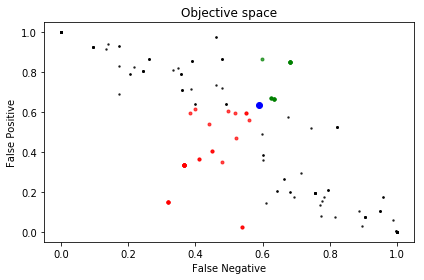

In [6]:
pop = toolbox.population(n=300)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

dominated = [ind for ind in pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in pop if not ind in dominated and not ind in dominators]

for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('False Negative');
plt.ylabel('False Positive');
plt.title('Objective space');
plt.tight_layout()
plt.show()


In [7]:
NGEN = 500
MU = 300
LAMBDA = 100
CXPB = 0.5
MUTPB = 0.4

random.seed(10)
pop = toolbox.population(n=MU)
# hof = tools.HallOfFame(1)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("min", np.min, axis=0)

#pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, halloffame=hof)
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)

gen	nevals	avg                    	min    
0  	300   	[0.62421569 0.40099628]	[0. 0.]
1  	93    	[0.62661064 0.34658287]	[0. 0.]
2  	91    	[0.67669468 0.29388268]	[0. 0.]
3  	94    	[0.63605042 0.33620112]	[0. 0.]
4  	89    	[0.61123249 0.34851024]	[0. 0.]
5  	92    	[0.5354902 0.4186406]  	[0. 0.]
6  	88    	[0.40060224 0.54663873]	[0. 0.]
7  	89    	[0.26997199 0.66344507]	[0. 0.]
8  	91    	[0.14028011 0.78317505]	[0. 0.]
9  	90    	[0.08316527 0.85343575]	[0. 0.]
10 	87    	[0.04977591 0.89002793]	[0. 0.]
11 	88    	[0.02714286 0.95475791]	[0. 0.]
12 	87    	[0.02717087 0.95527002]	[0. 0.]
13 	89    	[0.02731092 0.95468343]	[0. 0.]
14 	90    	[0.02935574 0.95112663]	[0. 0.]
15 	90    	[0.02619048 0.95297952]	[0. 0.]
16 	91    	[0.03140056 0.94548417]	[0. 0.]
17 	89    	[0.03226891 0.94303538]	[0. 0.]
18 	90    	[0.03288515 0.94121043]	[0. 0.]
19 	93    	[0.02963585 0.94422719]	[0. 0.]
20 	88    	[0.02704482 0.94942272]	[0. 0.]
21 	92    	[0.0282493  0.94599628]	[0. 0.]
22 	90    	

Best individual is: not_(and_(and_(and_(or_(IN4, and_(lt(if_then_else(lt(protectedDiv(IN3, if_then_else(IN5, IN0, IN1)), protectedDiv(IN3, IN3)), 0.5693569244220248, if_then_else(True, IN0, IN2)), IN1), or_(and_(IN6, IN5), IN8))), or_(IN6, IN4)), and_(lt(if_then_else(lt(IN0, IN1), protectedDiv(0.3126928541479178, IN2), protectedDiv(if_then_else(IN4, IN0, IN0), IN1)), IN1), or_(or_(or_(IN8, or_(not_(lt(IN0, IN1)), and_(or_(eq(protectedDiv(protectedDiv(0.40218891493062603, IN1), mul(IN2, IN0)), IN3), IN8), or_(IN6, not_(lt(if_then_else(not_(IN8), IN0, if_then_else(IN4, protectedDiv(IN0, 0.7165997540817547), IN0)), IN3)))))), and_(and_(or_(IN7, and_(True, or_(True, IN8))), or_(IN5, and_(and_(IN4, True), lt(protectedDiv(0.8190662885778611, IN2), protectedDiv(IN0, IN3))))), and_(lt(if_then_else(lt(IN0, IN1), 0.5693569244220248, IN0), IN1), or_(IN4, False)))), True))), and_(lt(if_then_else(lt(mul(add(IN2, IN1), mul(IN1, IN1)), IN1), 0.5693569244220248, sub(mul(IN3, IN2), protectedDiv(IN1, IN

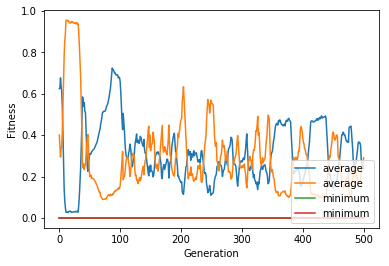

In [8]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

gen, avg, min_ = logbook.select("gen", "avg", "min")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
# plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

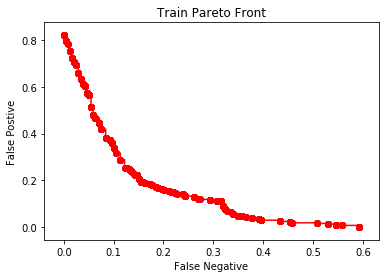

Area Under Curve: 0.10237782263743486


In [9]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Negative")
plt.ylabel("False Postive")
plt.title("Train Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

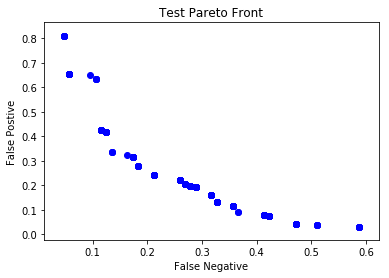

Area Under Curve: 0.1198147402335884


In [10]:
# Test cross-folded test set

hof_new = tools.ParetoFront()

for ind in hof:
    func = gp.compile(ind, pset)
    y_pred = [bool(func(*data)) for data in X_test.values]
    tn, fp, fn, tp = confusion_matrix(y_test.values, y_pred).ravel()
    fp_rate = fp / (fp + tn)
    fn_rate = fn / (fn + tp)
    
    ind.fitness.values = [fn_rate, fp_rate]

hof_new.update(hof)
      
fitness_1 = [ind.fitness.values[0] for ind in hof_new]
fitness_2 = [ind.fitness.values[1] for ind in hof_new]

plt.scatter(fitness_1, fitness_2, color='b')

plt.xlabel("False Negative")
plt.ylabel("False Postive")
plt.title("Test Pareto Front")
plt.show() 

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))    

# for x in hof_new:
#   print(x.fitness)

In [ ]:

nodes, edges, labels = gp.graph(hof_new[1])

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")

In [12]:
functions = [gp.compile(ind, pset) for ind in hof_new]
pred_df = pd.DataFrame(index=test_data.index)
col_names = [f"Tree_{x}_Survived" for x in range(len(functions))]

for i, function in enumerate(functions):
  pred_df[col_names[i]] = [int(bool(function(*person_data))) for person_data in test_data.values]
print(pred_df.columns)

Index(['Tree_0_Survived', 'Tree_1_Survived', 'Tree_2_Survived',
       'Tree_3_Survived', 'Tree_4_Survived', 'Tree_5_Survived',
       'Tree_6_Survived', 'Tree_7_Survived', 'Tree_8_Survived',
       'Tree_9_Survived',
       ...
       'Tree_447_Survived', 'Tree_448_Survived', 'Tree_449_Survived',
       'Tree_450_Survived', 'Tree_451_Survived', 'Tree_452_Survived',
       'Tree_453_Survived', 'Tree_454_Survived', 'Tree_455_Survived',
       'Tree_456_Survived'],
      dtype='object', length=457)


In [ ]:
pred_df.to_csv('predictions.csv', header=True, sep=',')